# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [51]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


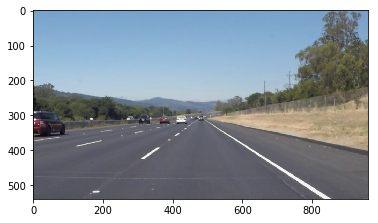

In [53]:
#reading in an image
image = mpimg.imread('test-images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

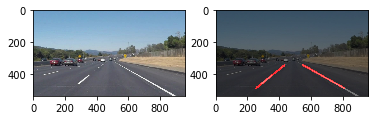

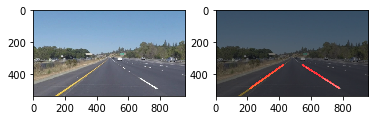

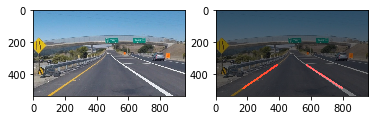

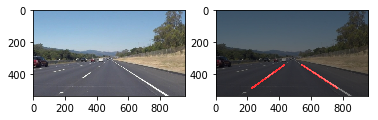

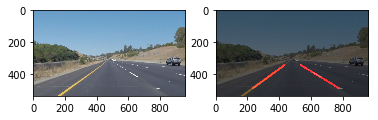

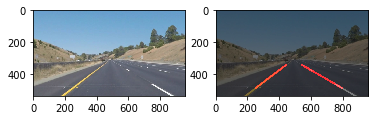

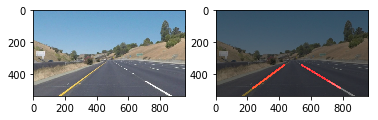

In [41]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    The following routine has been modified to average out the draw lines function

    First the slope of each and every line from the frame is computed.
    The slope is separated into the left half and the right half of the image/video
    The bias, which is a constant, is computed as an average of all the parallel lines in one half of the image
    The x co-ordinates of the far min of the line and the far maximum of the line is calculated for each half odf the image
    A line is drawn from the far x,y to the far right x,y co ordinate
    """
    
    # define arrays to store slope values
    slope_left = []
    slope_right = []
    
    # define arrays to store bias of the line
    c_left = []
    c_right = []
    
    # Iterate through all the lines found in the Hough transform
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            # calculate slope
            m = (y2-y1)/(x2-x1)
            
            # determine if the slope is in the left half, the range is to ensure we dont include vertical or horizontal lines
            if -1 < m < -0.3:
                
                # store the value of the slope, to calculate the bias and co-ordinates
                slope_left.append(m)
                
                # calculate bias
                c_left.append(y1 - m * x1)
            
            # determine if the slope is in the right half
            elif 1 > m > 0.3:
                slope_right.append(m)
                c_right.append(y1 - m * x1)
    
    # define the region of interest
    # these co ordinates form a trapezium on the image
    # adapt the vertices such that the shape of the image is considered (980 X 540) vs (1280 X 780)
    
    left_bottom = (100, np.shape(img)[0] - 50)
    right_bottom = (np.shape(img)[1] - 100, np.shape(img)[0] - 50)
    left_top = (int(np.shape(img)[1]/2) - 50, int(np.shape(img)[0]/2) + 75)
    right_top = (int(np.shape(img)[1]/2) + 50, int(np.shape(img)[0]/2) + 75)
    
    # ensure the arrays are not empty
    if len(c_left) > 0 and len(slope_left) > 0:
        
        # find the min x co ordinate given the bottom left vertex and using  y = mx + c
        # x_min is the bottom left extreme of the lane
        x_min = (left_bottom[1] - np.nanmean(c_left))/np.nanmean(slope_left)
        
        # x_left is the x co ordinate of top left extreme of the region of interest
        x_left = (left_top[1] - np.nanmean(c_left))/np.nanmean(slope_left)
        
        # draw a line from the top left lane co ordinates to the bottom left lane co ordinates on the left side of the image
        cv2.line(img, (int(x_left), left_top[1]), (int(x_min), left_bottom[1]), color, thickness)

    if len(c_right) > 0 and len(slope_right) > 0:
        
        # find the min x co ordinate given the bottom left vertex and using  y = mx + c
        # x_min is the bottom left extreme of the lane
        x_max = (right_bottom[1] - np.nanmean(c_right))/np.nanmean(slope_right)
        
        # x_left is the x co ordinate of top left extreme of the region of interest
        x_right = (right_top[1] - np.nanmean(c_right))/np.nanmean(slope_right)
        
        # draw a line from the top left lane co ordinates to the bottom left lane co ordinates on the left side of the image
        cv2.line(img, (int(x_right), right_top[1]), (int(x_max), right_bottom[1]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Load all test cases into a variable called Test_Cases
test_cases =  os.listdir("/home/prabhat/Downloads/pycharm-community-2017.3.1/bin/test-images/")

# Run the pipeline for each test case
for image in test_cases:
    test_image = mpimg.imread("/home/prabhat/Downloads/pycharm-community-2017.3.1/bin/test-images/"+image)
    

    # Read in the image
    image = test_image
    # Display the image
    plt.subplot(121)
    plt.imshow(image)
    #plt.show()
    # Create a copy
    img_copy = np.copy(image)

    # Convert to grayscale
    gray = grayscale(img_copy)
    #plt.subplot(332)
    #plt.imshow(gray)
    #plt.show()

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    #plt.subplot(333)
    #plt.imshow(blur_gray)
    #plt.show()

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.subplot(334)
    #plt.imshow(masked_edges)
    #plt.show()

    # Specify the region of interest
    #left_bottom = (50, 520)
    #right_bottom = (910, 520)
    #left_top = (430, 340)
    #right_top = (530, 340)
    
    left_bottom = (100, np.shape(image)[0] - 50)
    right_bottom = (np.shape(image)[1] - 100, np.shape(image)[0] - 50)
    left_top = (int(np.shape(image)[1]/2) - 50, int(np.shape(image)[0]/2) + 75)
    right_top = (int(np.shape(image)[1]/2) + 50, int(np.shape(image)[0]/2) + 75)

    points = np.array([left_bottom, right_bottom, right_top, left_top])

    clipped_image = region_of_interest(masked_edges, [points])
    # Display the image
    #plt.subplot(335)
    #plt.imshow(clipped_image)
    #plt.show()

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 5
    max_line_gap = 3

    # Run Hough on edge detected image
    lines = hough_lines(clipped_image, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.subplot(336)
    #plt.imshow(lines)
    #plt.show()

    # Draw the lines on the edge image
    combo = weighted_img(lines, img_copy, 0.5, 1, 0)
    plt.subplot(122)
    plt.imshow(combo)
    plt.show()
    
    

## Build a Lane Finding Pipeline


Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [42]:
import imageio
imageio.plugins.ffmpeg.download()

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    img = image
    # Create a copy
    img_copy = np.copy(img)

    # Convert to grayscale
    gray = grayscale(img_copy)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    
    img_size = clip.get_frame(1)

    # define region of interest globally
    # the origin is the top left of the image
    # read in the image shape so the region of interset can be adjusted
    left_bottom = (100, np.shape(img_size)[0] - 50)
    right_bottom = (np.shape(img_size)[1] - 100, np.shape(img_size)[0] - 50)
    left_top = (int(np.shape(img_size)[1]/2) - 50, int(np.shape(img_size)[0]/2) + 75)
    right_top = (int(np.shape(img_size)[1]/2) + 50, int(np.shape(img_size)[0]/2) + 75)

    points = np.array([left_bottom, right_bottom, right_top, left_top])

    clipped_image = region_of_interest(masked_edges, [points])

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 5
    max_line_gap = 3

    # Run Hough on edge detected image
    lines = hough_lines(clipped_image, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    result = weighted_img(lines, img_copy, 0.5, 1, 0)

    return result

Let's try the one with the solid white lane on the right first ...

In [45]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("test-videos/solidWhiteRight.mp4")
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, codec = 'mpeg4', audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 78%|███████▊  | 173/222 [00:27<00:08,  5.76it/s]


100%|█████████▉| 221/222 [00:35<00:00,  5.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.34 s, sys: 4.24 s, total: 8.58 s
Wall time: 35.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [47]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip = VideoFileClip('test-videos/solidYellowLeft.mp4')
yellow_clip = clip.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, codec = 'mpeg4', audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 26%|██▌       | 176/682 [00:29<01:30,  5.59it/s]


 48%|████▊     | 330/682 [00:54<00:55,  6.32it/s]


 71%|███████   | 484/682 [01:20<00:31,  6.38it/s]


 94%|█████████▎| 638/682 [01:45<00:07,  6.24it/s]


100%|█████████▉| 681/682 [01:52<00:00,  5.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.4 s, sys: 11.5 s, total: 22.9 s
Wall time: 1min 52s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [49]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip = VideoFileClip('test-videos/challenge.mp4')
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, codec = 'mpeg4', audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 62%|██████▏   | 156/251 [00:54<00:33,  2.80it/s]


100%|██████████| 251/251 [01:28<00:00,  2.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.3 s, sys: 8.05 s, total: 18.4 s
Wall time: 1min 28s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))